# Lab 1 - Series temporales


In [ ]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [90]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [91]:
plt.rcParams['figure.figsize'] = [15, 10]

## 1 - Levantar los datos 
Desde el archivo dataset/Telefonia_movil.csv. Los mismos fueron extraídos de http://datosabiertos.enacom.gob.ar/visualizations/29890/trafico-de-suscriptores-de-telefonia-movil-miles-de-minutos/ 

In [92]:
data=pd.read_csv('datasets/Telefonia_movil.csv', parse_dates=True, dayfirst=True)

## 2 - Explorar los datos, visualizarlos

In [93]:
data.describe()

,Año,Trimestre,Minutos prepago salientes (miles),Total de minutos salientes (miles)
count,22.000000,22.000000,2.200000e+01,2.200000e+01
mean,2015.272727,2.409091,6.604273e+06,1.870118e+07
std,1.638287,1.140555,5.251805e+05,1.990543e+06
min,2013.000000,1.000000,5.380710e+06,1.536806e+07
25%,2014.000000,1.250000,6.291007e+06,1.735731e+07
50%,2015.000000,2.000000,6.580968e+06,1.883452e+07
75%,2016.750000,3.000000,7.100940e+06,1.974379e+07
max,2018.000000,4.000000,7.335154e+06,2.289966e+07


In [94]:
data.dtypes

Año                                    int64
Trimestre                              int64
Minutos pospago salientes (miles)     object
Minutos prepago salientes (miles)      int64
Total de minutos salientes (miles)     int64
Periodo                               object
dtype: object

In [95]:
data.head()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
0,2013,1,8.785.943,6582117,15368060,Ene-Mar 2013
1,2013,2,9.512.689,7108640,16621329,Abr-Jun 2013
2,2013,3,10.315.484,7335154,17650638,Jul-Sept 2013
3,2013,4,9.809.515,6250549,16060064,Oct-Dic 2013
4,2014,1,10.128.751,5799223,15927974,Ene-Mar 2013


In [96]:
data = data.rename(columns={
    'Año' : 'Year',
    'Minutos pospago salientes (miles)': 'MinutosPospagoSalientes', 
    'Minutos prepago salientes (miles)': 'MinutosPrepagoSalientes', 
    'Total de minutos salientes (miles)': 'TotalMinutosSalientes'})

In [97]:
data.head()

,Year,Trimestre,MinutosPospagoSalientes,MinutosPrepagoSalientes,TotalMinutosSalientes,Periodo
0,2013,1,8.785.943,6582117,15368060,Ene-Mar 2013
1,2013,2,9.512.689,7108640,16621329,Abr-Jun 2013
2,2013,3,10.315.484,7335154,17650638,Jul-Sept 2013
3,2013,4,9.809.515,6250549,16060064,Oct-Dic 2013
4,2014,1,10.128.751,5799223,15927974,Ene-Mar 2013


In [98]:
def set_Fecha (row):
   if row['Trimestre'] == 1 :
      return str(row['Year']) + '-03-01'
   if row['Trimestre'] == 2 :
      return str(row['Year']) + '-06-01'
   if row['Trimestre'] == 3 :
      return str(row['Year']) + '-09-01'
   if row['Trimestre'] == 4 :
      return str(row['Year']) + '-12-01'
   return Nan

In [99]:
data['Fecha'] = data.apply (lambda row: set_Fecha (row),axis=1)
data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)
data.index=data.index.to_period(freq='Q')
data.tail()

,Year,Trimestre,MinutosPospagoSalientes,MinutosPrepagoSalientes,TotalMinutosSalientes,Periodo
Fecha,,,,,,
2017Q2,2017,2,15.315.167,6293563,21608730,Abr-Jun 2017
2017Q3,2017,3,15.106.275,6308373,21414647,Jul-Sept 2017
2017Q4,2017,4,14.164.552,5380710,19545262,Oct-Dic 2017
2018Q1,2018,1,13.851.254,5958717,19809971,Ene-Mar 2018
2018Q2,2018,2,14.388.755,6290155,20678910,Abr-Jun 2018


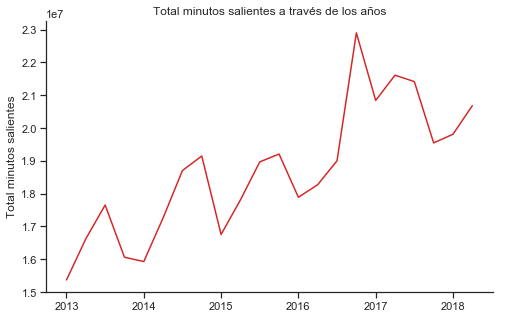

In [100]:
y=data['TotalMinutosSalientes']
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Total minutos salientes')
ax.set_title('Total minutos salientes a través de los años')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

## Implementar dos modelos (como ser Random Walk (Naïve) y Exponential Smoothing)

# Random walk

In [101]:
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2018Q3    20678910
2018Q4    20678910
2019Q1    20678910
2019Q2    20678910
Freq: Q-DEC, dtype: int64

In [102]:
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

1464911.401

In [103]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2018Q3,1.780774e+07,2.355008e+07
2018Q4,1.661846e+07,2.473936e+07
2019Q1,1.570589e+07,2.565193e+07
2019Q2,1.493656e+07,2.642126e+07


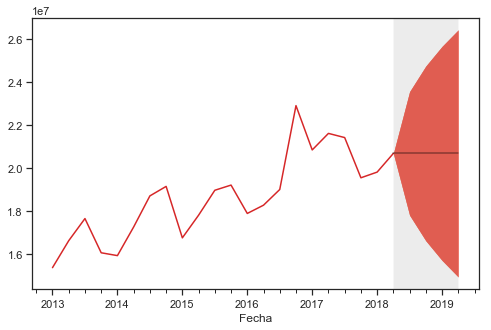

In [104]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y['2010':],point_pred,intv,intv,intv)

plt.show()

# Simple exponential smoothing

In [105]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues
# model_ses.summary() # summary isn't implemented in 0.9, looks it'll be avaible in 0.10
alpha_ses = model_ses.model.params['smoothing_level']
mse_ses = sm.tools.eval_measures.mse(y,fitted_ses)
# loglik_ses = model_ses.model.loglike(model_ses.model.params) # NotImplementedError
aic_ses = model_ses.aic
bic_ses = model_ses.bic
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_ses))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Smoothing parameter: alpha  0.535
 In-sample fit:
 MSE               1843938379587.524
 AIC               625.344
 BIC               627.526


In [106]:
N = len(y)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -341.889
 AIC               689.778
 BIC               693.051


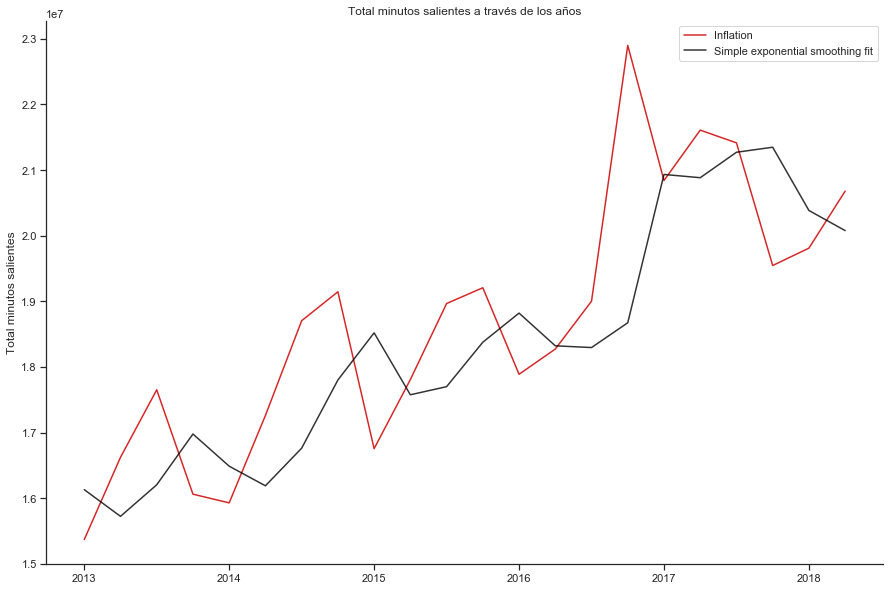

In [107]:
fig, ax= plt.subplots(figsize=(15,10))
y.plot(color=red, label='Inflation')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Total minutos salientes')
ax.set_title('Total minutos salientes a través de los años')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

# Forecast

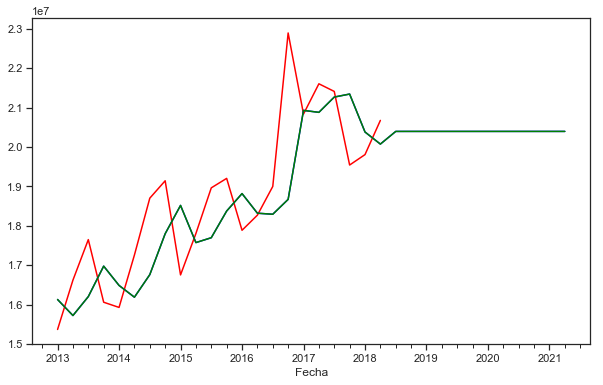

In [108]:
h=12
w=h*10
data = y
model = sm.tsa.SimpleExpSmoothing
pred_index = y.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red',figsize=(10,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');